In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import csv
from sklearn.impute import KNNImputer

# Introduction
Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# Define the target questions

# Data Loading

In [42]:
df_list = []
with open("HomeCredit_columns_description.csv", 'r',errors='ignore') as file:
    reader = csv.reader(file)
    for row in reader:
        df_list.append(pd.DataFrame({'table_name':row[1],'col_name':row[2],\
                                     'description':row[3]},index=list('A')))
df_description = pd.concat(df_list,axis=0).reset_index()
df_description.drop(columns='index',inplace=True)

In [43]:
def view_description_columns(table,data=df_description,column=None):
    """
    view_description_columns(table,data=df_description,column=None) designed for columns descriptions check
    :param table:
    :param data:
    :param column:
    :return: The descriptions of each column for corresponding table
    """
    if column is not None:
        return data[(data['table_name']==table)&(df_description['col_name']==column)][['col_name','description']]
    else:
        return data[data['table_name']==table][['col_name','description']]
    

## Previsous Application `prev_applic` columns description

In [44]:
# Read Previous Application table
previous_application = pd.read_csv('previous_application.csv')

In [85]:
previous_application_description = view_description_columns(table='previous_application.csv',data=df_description)

In [142]:
previous_application_description.head(10)

,col_name,description
174,SK_ID_PREV,ID of previous credit in Home credit related t...
175,SK_ID_CURR,ID of loan in our sample
176,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa..."
177,AMT_ANNUITY,Annuity of previous application
178,AMT_APPLICATION,For how much credit did client ask on the prev...
179,AMT_CREDIT,Final credit amount on the previous applicatio...
180,AMT_DOWN_PAYMENT,Down payment on the previous application
181,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...
182,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...
183,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client ...


## Installments `installments` columns description

In [46]:
installments  = pd.read_csv('installments_payments.csv')

In [86]:
installments_description = view_description_columns(table='installments_payments.csv',data=df_description)

In [147]:
installments_description.head(10)

,col_name,description
212,SK_ID_PREV,ID of previous credit in Home credit related t...
213,SK_ID_CURR,ID of loan in our sample
214,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for cred...
215,NUM_INSTALMENT_NUMBER,On which installment we observe payment
216,DAYS_INSTALMENT,When the installment of previous credit was su...
217,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...
218,AMT_INSTALMENT,What was the prescribed installment amount of ...
219,AMT_PAYMENT,What the client actually paid on previous cred...


## POS_CASH_Balance ` pos_cash_bal` column descriptions

In [48]:
pos_cash_bal = pd.read_csv('POS_CASH_balance.csv')

In [87]:
pos_cash_bal_description = view_description_columns(table='POS_CASH_balance.csv',data=df_description)

In [148]:
pos_cash_bal_description.head(10)

,col_name,description
143,SK_ID_PREV,ID of previous credit in Home Credit related t...
144,SK_ID_CURR,ID of loan in our sample
145,MONTHS_BALANCE,Month of balance relative to application date ...
146,CNT_INSTALMENT,Term of previous credit (can change over time)
147,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit
148,NAME_CONTRACT_STATUS,Contract status during the month
149,SK_DPD,DPD (days past due) during the month of previo...
150,SK_DPD_DEF,DPD during the month with tolerance (debts wit...


## Credit card balance `credit_card_bal` columns description

In [50]:
credit_card_bal = pd.read_csv('credit_card_balance.csv')

In [88]:
credit_card_bal_description = view_description_columns('credit_card_balance.csv',data=df_description)

In [149]:
credit_card_bal_description.head(10)

,col_name,description
151,SK_ID_PREV,ID of previous credit in Home credit related t...
152,SK_ID_CURR,ID of loan in our sample
153,MONTHS_BALANCE,Month of balance relative to application date ...
154,AMT_BALANCE,Balance during the month of previous credit
155,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the prev...
156,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the ...
157,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previou...
158,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of t...
159,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the mont...
160,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the prev...


## Bureau `bureau` columns description
- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [52]:
bureau = pd.read_csv('bureau.csv')

In [89]:
bureau_description = view_description_columns('bureau.csv',data=df_description)

In [150]:
bureau_description.head(10)

,col_name,description
123,SK_ID_CURR,ID of loan in our sample - one loan in our sam...
124,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit re...
125,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits
126,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit
127,DAYS_CREDIT,How many days before current application did c...
128,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the ti...
129,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at t...
130,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of appl...
131,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau cr...
132,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit pr...


## Bureau balance `bureau_applic` columns description
- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [90]:
bureau_bla = pd.read_csv('bureau_balance.csv')

In [92]:
bureau_bla_description = view_description_columns('bureau_balance.csv',data=df_description)

In [151]:
bureau_bla_description.head()

,col_name,description
140,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...
141,MONTHS_BALANCE,Month of balance relative to application date ...
142,STATUS,Status of Credit Bureau loan during the month ...


## `Application {train/test}` Columns Description

In [56]:
application_train = pd.read_csv('application_train.csv')

In [57]:
application_test = pd.read_csv('application_test.csv')

In [159]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis and Data Processing

## Data Visualizations

### 1. Application Data

Application train

Application test

Overview Application dataset

In [58]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


1.1 Distribution of Target Variable

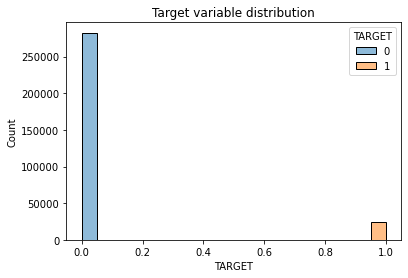

In [69]:
sns.histplot(x='TARGET',hue='TARGET',data=application_train,kde=False)
plt.title('Target variable distribution')
plt.show()

In [79]:
application_train_corr = application_train.corr().abs()
application_train_corr['TARGET'].sort_values(ascending=False).head(6)

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
Name: TARGET, dtype: float64

In [78]:
application_train.select_dtypes(include='object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [96]:
application_train.var().sort_values(ascending = False).head(10)

/var/folders/xy/406yv2ts4sqg09841vwh_phm0000gn/T/ipykernel_15541/423123096.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  application_train.var().sort_values(ascending = False).head(10)


AMT_CREDIT                1.619988e+11
AMT_GOODS_PRICE           1.364907e+11
AMT_INCOME_TOTAL          5.622739e+10
DAYS_EMPLOYED             1.995884e+10
SK_ID_CURR                1.056582e+10
AMT_ANNUITY               2.100684e+08
DAYS_BIRTH                1.904440e+07
DAYS_REGISTRATION         1.241073e+07
DAYS_ID_PUBLISH           2.278441e+06
DAYS_LAST_PHONE_CHANGE    6.836123e+05
dtype: float64

1.2 External Source

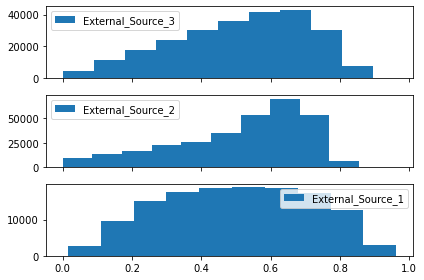

In [169]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
ax1.hist(application_train['EXT_SOURCE_3'],label='External_Source_3')
ax1.legend()
ax2.hist(application_train['EXT_SOURCE_2'],label='External_Source_2')
ax2.legend()
ax3.hist(application_train['EXT_SOURCE_1'],label='External_Source_1')
ax3.legend()
plt.tight_layout()
plt.show()

1.3 DAYS_BIRTH

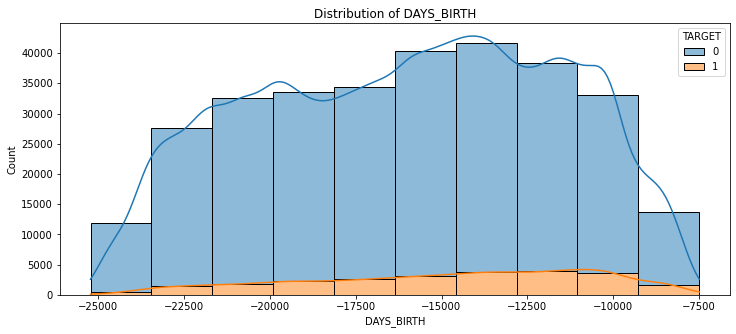

In [131]:
plt.figure(figsize=(12,5))
sns.histplot(x = 'DAYS_BIRTH',bins = 10,kde=True,
             hue='TARGET',data=application_train,multiple='stack')
plt.title("Distribution of DAYS_BIRTH")
plt.show()

1.4 REGION_RATING_CLIENT_W_CITY

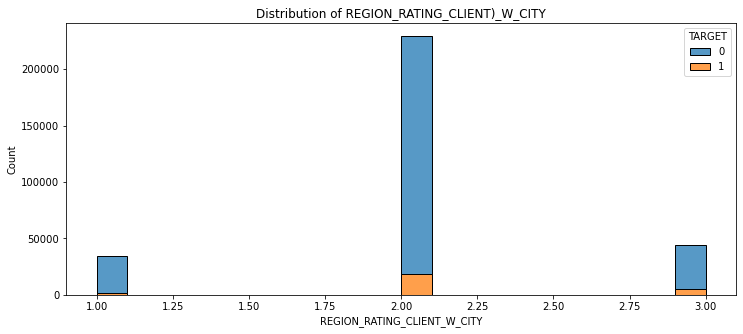

In [135]:
plt.figure(figsize=(12,5))
sns.histplot(x='REGION_RATING_CLIENT_W_CITY',hue='TARGET',data=application_train,multiple='stack')
plt.title("Distribution of REGION_RATING_CLIENT)_W_CITY")
plt.show()

1.5 NAME_INCOME_TYPE

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Working'),
  Text(1, 0, 'State servant'),
  Text(2, 0, 'Commercial associate'),
  Text(3, 0, 'Pensioner'),
  Text(4, 0, 'Unemployed'),
  Text(5, 0, 'Student'),
  Text(6, 0, 'Businessman'),
  Text(7, 0, 'Maternity leave')])

<Figure size 864x360 with 0 Axes>

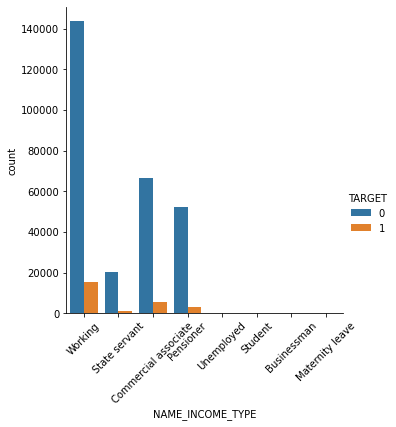

In [119]:
plt.figure(figsize=(12,5))
sns.catplot(data=application_train,x='NAME_INCOME_TYPE',kind='count',hue='TARGET')
plt.xticks(rotation=45)
plt.show()

<Figure size 864x360 with 0 Axes>

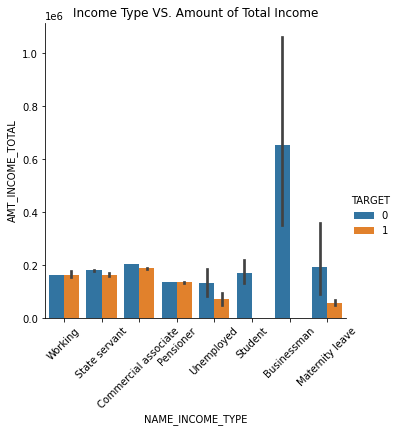

In [127]:
plt.figure(figsize=(12,5))
sns.catplot(data=application_train,x='NAME_INCOME_TYPE',y='AMT_INCOME_TOTAL'
            ,hue='TARGET',kind='bar')
plt.xticks(rotation=45)
plt.title('Income Type VS. Amount of Total Income')
plt.show()

1.6 NAME_EDUCATION_TYPE

<Figure size 864x360 with 0 Axes>

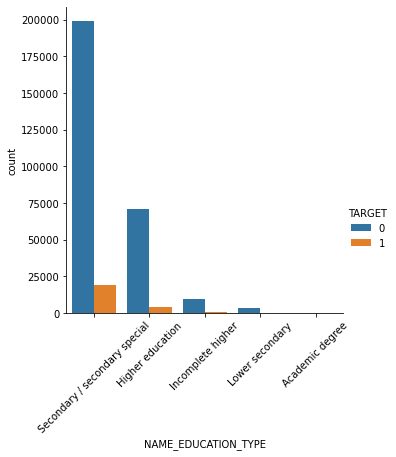

In [128]:
plt.figure(figsize=(12,5))
sns.catplot(data=application_train,x='NAME_EDUCATION_TYPE',kind='count',hue='TARGET')
plt.xticks(rotation=45)
plt.show()

<Figure size 864x360 with 0 Axes>

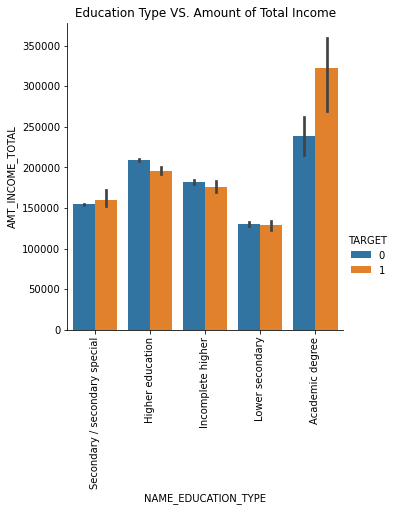

In [141]:
plt.figure(figsize=(12,5))
sns.catplot(data=application_train,x='NAME_EDUCATION_TYPE',y='AMT_INCOME_TOTAL'
            ,hue='TARGET',kind='bar',estimator=np.mean)
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

1.7 NAME_FAMILY_STATUS

<Figure size 864x360 with 0 Axes>

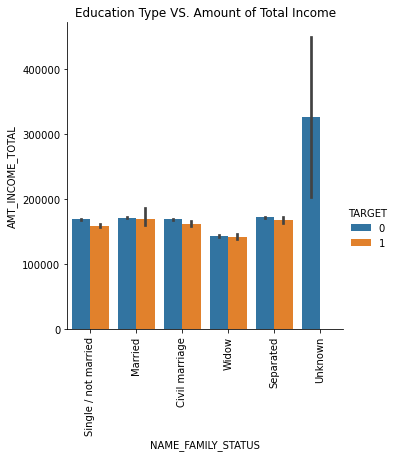

In [160]:
plt.figure(figsize=(12,5))
sns.catplot(data=application_train,x='NAME_FAMILY_STATUS',y='AMT_INCOME_TOTAL'
            ,hue='TARGET',kind='bar',estimator=np.mean)
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

1.8 OCCUPATION_TYPE

<Figure size 1440x720 with 0 Axes>

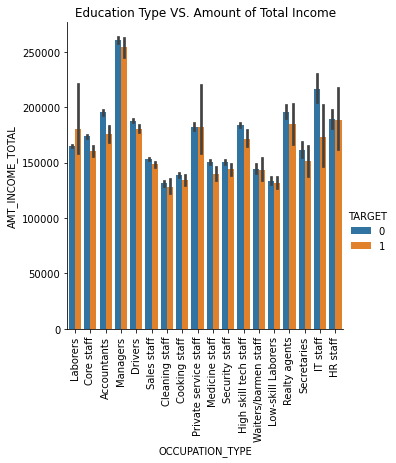

<Figure size 1440x720 with 0 Axes>

In [170]:
plt.figure(figsize=(20,10))
sns.catplot(data=application_train,x='OCCUPATION_TYPE',y='AMT_INCOME_TOTAL'
            ,hue='TARGET',kind='bar',estimator=np.mean)
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

1.9 ORGANIZATION_TYPE

<Figure size 2160x1440 with 0 Axes>

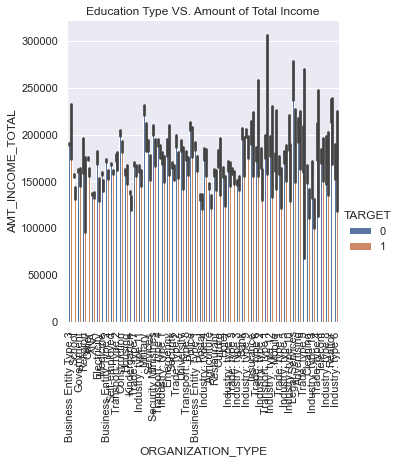

In [175]:
plt.figure(figsize=(30,20))
sns.catplot(data=application_train,x='ORGANIZATION_TYPE',y='AMT_INCOME_TOTAL'
            ,hue='TARGET',kind='bar',estimator=np.mean)
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

1.10 WEEKDAY_APPR_PROCESS_START

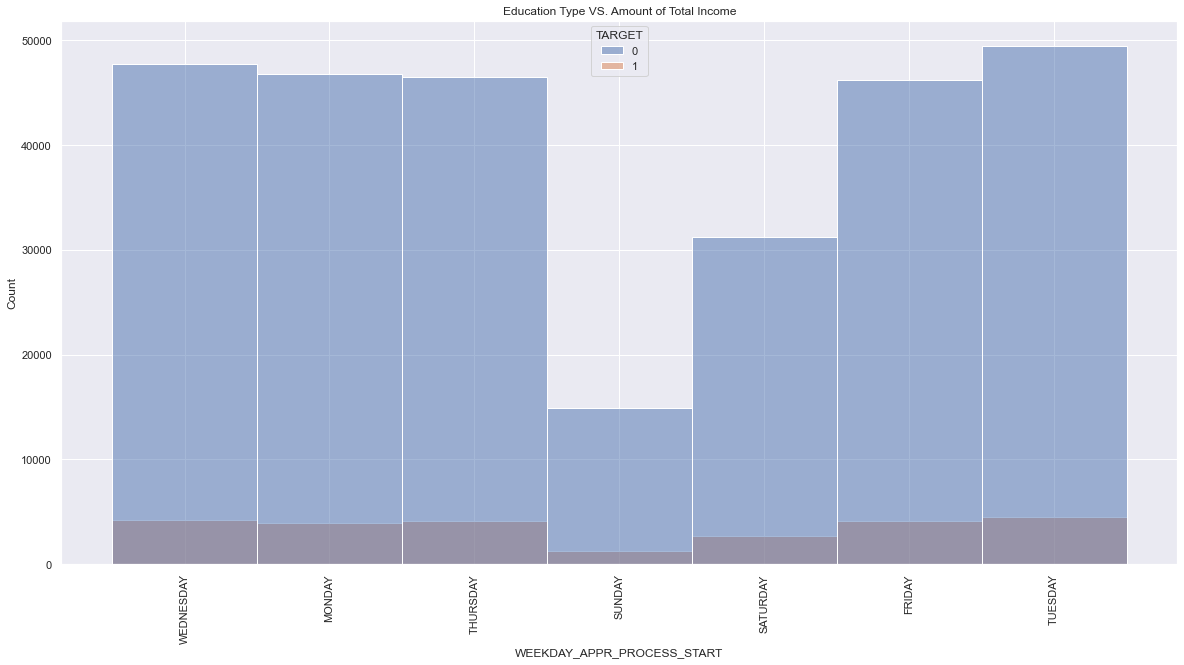

In [178]:
plt.figure(figsize=(20,10))
sns.histplot(data=application_train,x='WEEKDAY_APPR_PROCESS_START'
            ,hue='TARGET')
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

### Bureau Data

Bureau data contains all client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in the sample). For every loan in the sample, there are as many rows as number of credits the client had in Credit Bureau before the application date. SK_ID_CURR is the key connecting application_train|test data with bureau data.

Let's merge application_train with bureau.

In [179]:
bureau_application = bureau.merge(application_train, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [189]:
bureau_application_corr = bureau_application.corr().abs()

bureau_application_corr_col = list(bureau.columns)
bureau_application_corr_col.append('TARGET')

bureau_application_corr[bureau_application_corr.columns.
                        isin(bureau_application_corr_col)]['TARGET'].sort_values(ascending = False)

In [223]:
bureau.select_dtypes(include='object').columns

Index(['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], dtype='object')

In [226]:
bureau['CREDIT_ACTIVE'].unique()

array(['Closed', 'Active', 'Sold', 'Bad debt'], dtype=object)

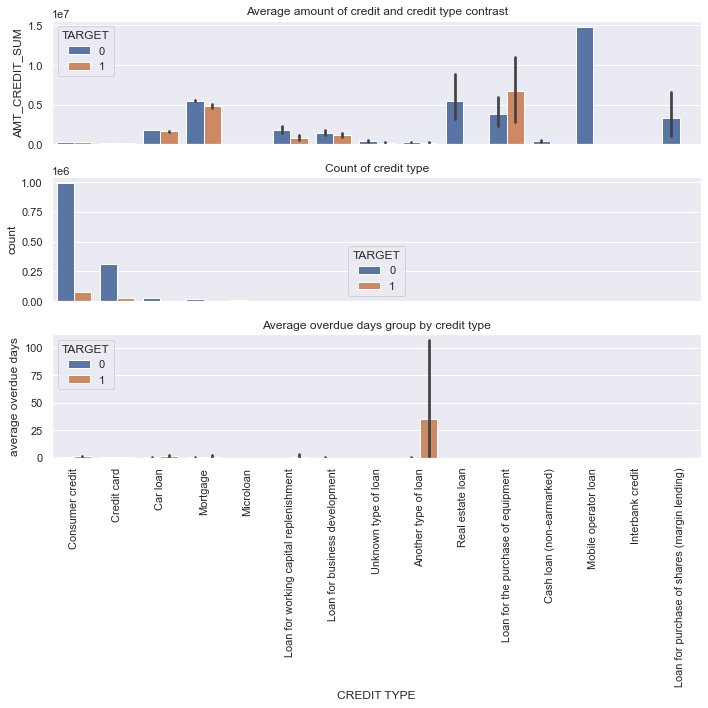

In [186]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,sharex=True,figsize= (10,10))
plt.subplot(3,1,1)
sns.barplot(data = bureau_application,x = 'CREDIT_TYPE',y='AMT_CREDIT_SUM',estimator=np.mean,ax = ax1,hue='TARGET')
plt.xticks(rotation = 90)
ax1.xaxis.set_visible(False)
plt.title('Average amount of credit and credit type contrast')
plt.subplot(3,1,2)
sns.countplot(data= bureau_application, x='CREDIT_TYPE',ax = ax2,hue='TARGET')
plt.xticks(rotation = 90)
plt.title('Count of credit type')
ax2.xaxis.set_visible(False)
plt.subplot(3,1,3)
sns.barplot(data= bureau_application, x = 'CREDIT_TYPE', y = 'CREDIT_DAY_OVERDUE', estimator=np.mean,ax = ax3,hue='TARGET')
plt.xticks(rotation = 90)
plt.xlabel('CREDIT TYPE')
plt.title('Average overdue days group by credit type')
plt.ylabel('average overdue days')
plt.tight_layout()
plt.show()

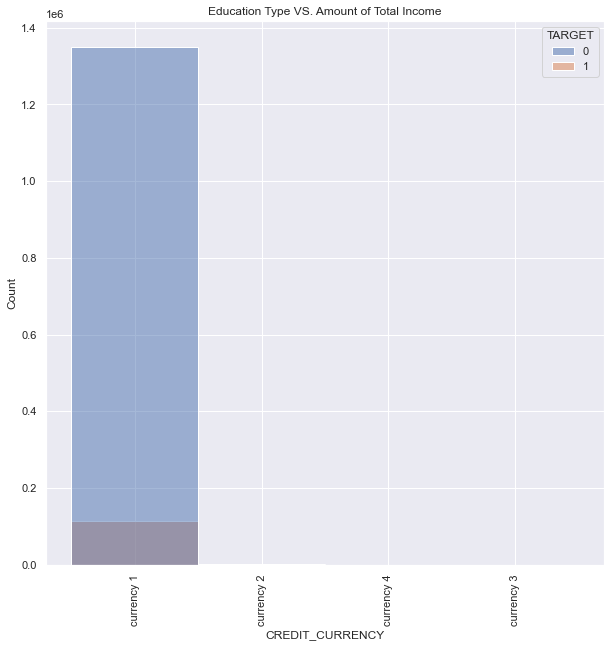

In [228]:
plt.figure(figsize=(10,10))
sns.histplot(data=bureau_application,x='CREDIT_CURRENCY'
            ,hue='TARGET')
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

In [257]:
currency_default_cnt = pd.DataFrame(bureau_application.groupby(['CREDIT_CURRENCY'])['TARGET'].value_counts())
currency_default_cnt['PERCENT'] = bureau_application.groupby(['CREDIT_CURRENCY'])['TARGET']\
.value_counts(normalize=True).values
currency_default_cnt

TARGET   PERCENT
CREDIT_CURRENCY TARGET                   
currency 1      0       1349640  0.921826
                1        114454  0.078174
currency 2      0          1023  0.954291
                1            49  0.045709
currency 3      0           133  0.886667
                1            17  0.113333
currency 4      0             9  1.000000

### Previous Data

The dataframe previous_application contains information about all previous applications for Home Credit loans of clients who have loans in the sample. There is one row for each previous application related to loans in our data sample. SK_ID_CURR is the key connecting application_train|test data with previous_application data.

Let's merge application_train with previous_application.

In [259]:
previous_application_application = previous_application.merge(application_train, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [269]:
previous_application_application_corr = previous_application_application.corr().abs()

previous_application_application_corr_col = list(previous_application.columns)
previous_application_application_corr_col.append('TARGET')



In [283]:
previous_application_application_corr[previous_application_application_corr.columns.
                        isin(previous_application_application_corr_col)]['TARGET'].\
sort_values(ascending=False).head(5)

TARGET                      1.000000
DAYS_DECISION               0.039901
DAYS_FIRST_DRAWING          0.031154
CNT_PAYMENT                 0.030480
RATE_INTEREST_PRIVILEGED    0.028640
Name: TARGET, dtype: float64

In [280]:
previous_application.select_dtypes(include='object').columns

Index(['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION'],
      dtype='object')

DAYS_DECISION

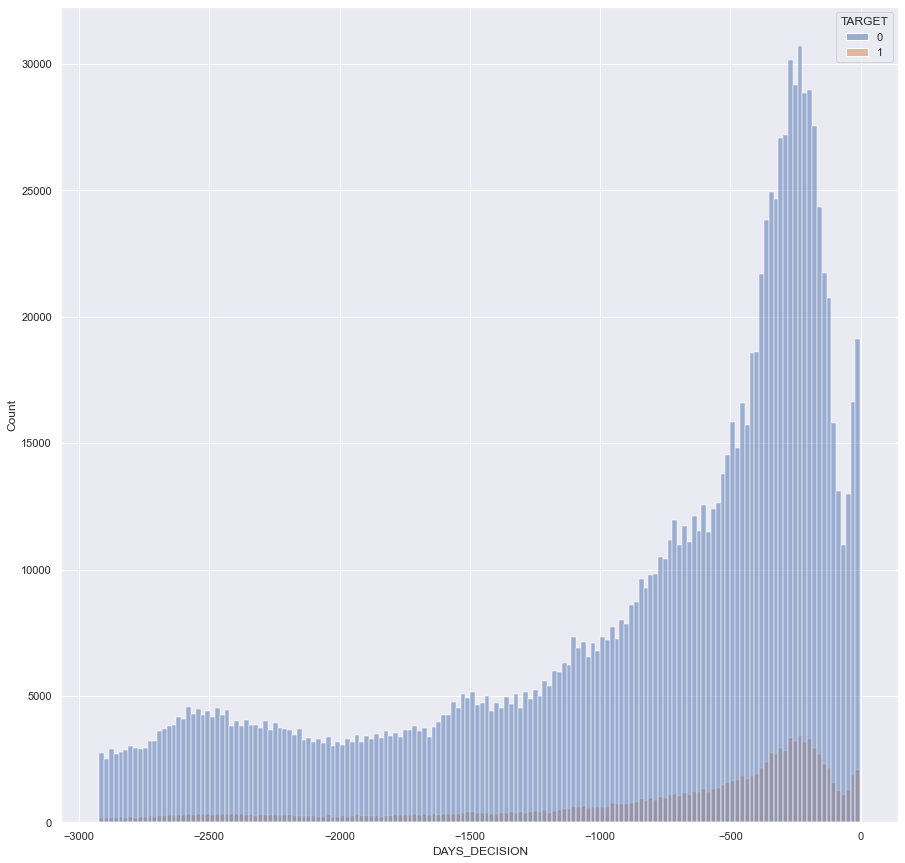

In [288]:
plt.figure(figsize=(15,15))
sns.histplot(x='DAYS_DECISION',data=previous_application_application,hue='TARGET')
plt.show()

CNT_PAYMENT

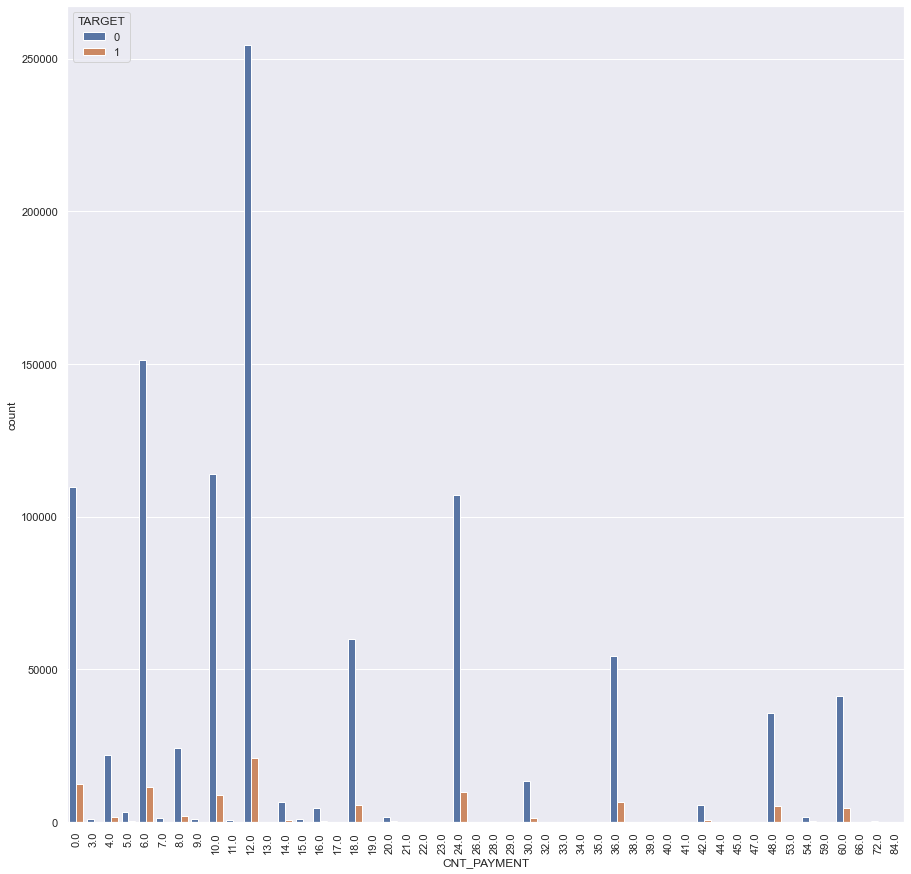

In [293]:
plt.figure(figsize=(15,15))
sns.countplot(x='CNT_PAYMENT',data=previous_application_application,hue='TARGET')
plt.xticks(rotation = 90)
plt.show()

NAME_CONTRACT_TYPE

<Figure size 2160x1440 with 0 Axes>

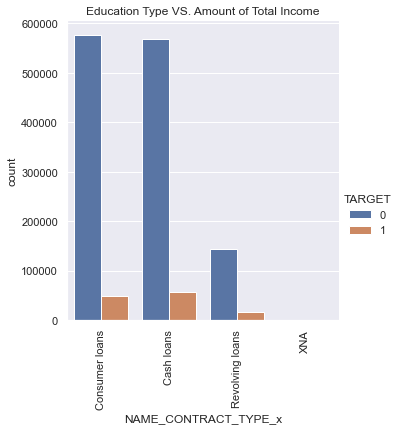

In [300]:
plt.figure(figsize=(30,20))
sns.catplot(data=previous_application_application,x='NAME_CONTRACT_TYPE_x'
            ,hue='TARGET',kind='count')
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

CODE_REJECT_REASON

<Figure size 2160x1440 with 0 Axes>

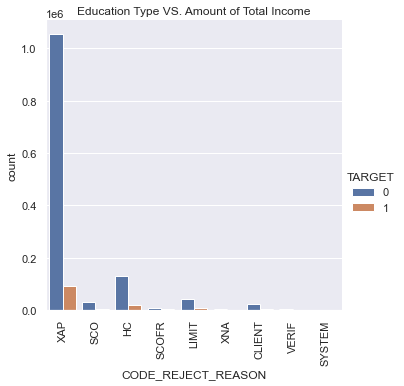

In [301]:
plt.figure(figsize=(30,20))
sns.catplot(data=previous_application_application,x='CODE_REJECT_REASON'
            ,hue='TARGET',kind='count')
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

#### Amount customers previously requested VS. Amount customers finally got approved

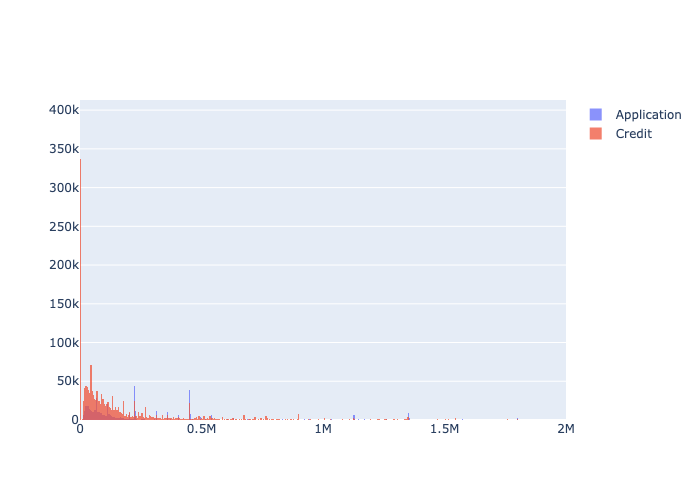

In [258]:
import plotly.graph_objects as go
x0 =prev_applic['AMT_APPLICATION']
x1 =prev_applic['AMT_CREDIT']
fig = go.Figure()
fig.add_trace(go.Histogram(x=x0,name='Application'))
fig.add_trace(go.Histogram(x=x1,name='Credit'))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity = 0.75)
fig.update_xaxes(range=[0,2000000])
fig.show('png')

#### Average goods price

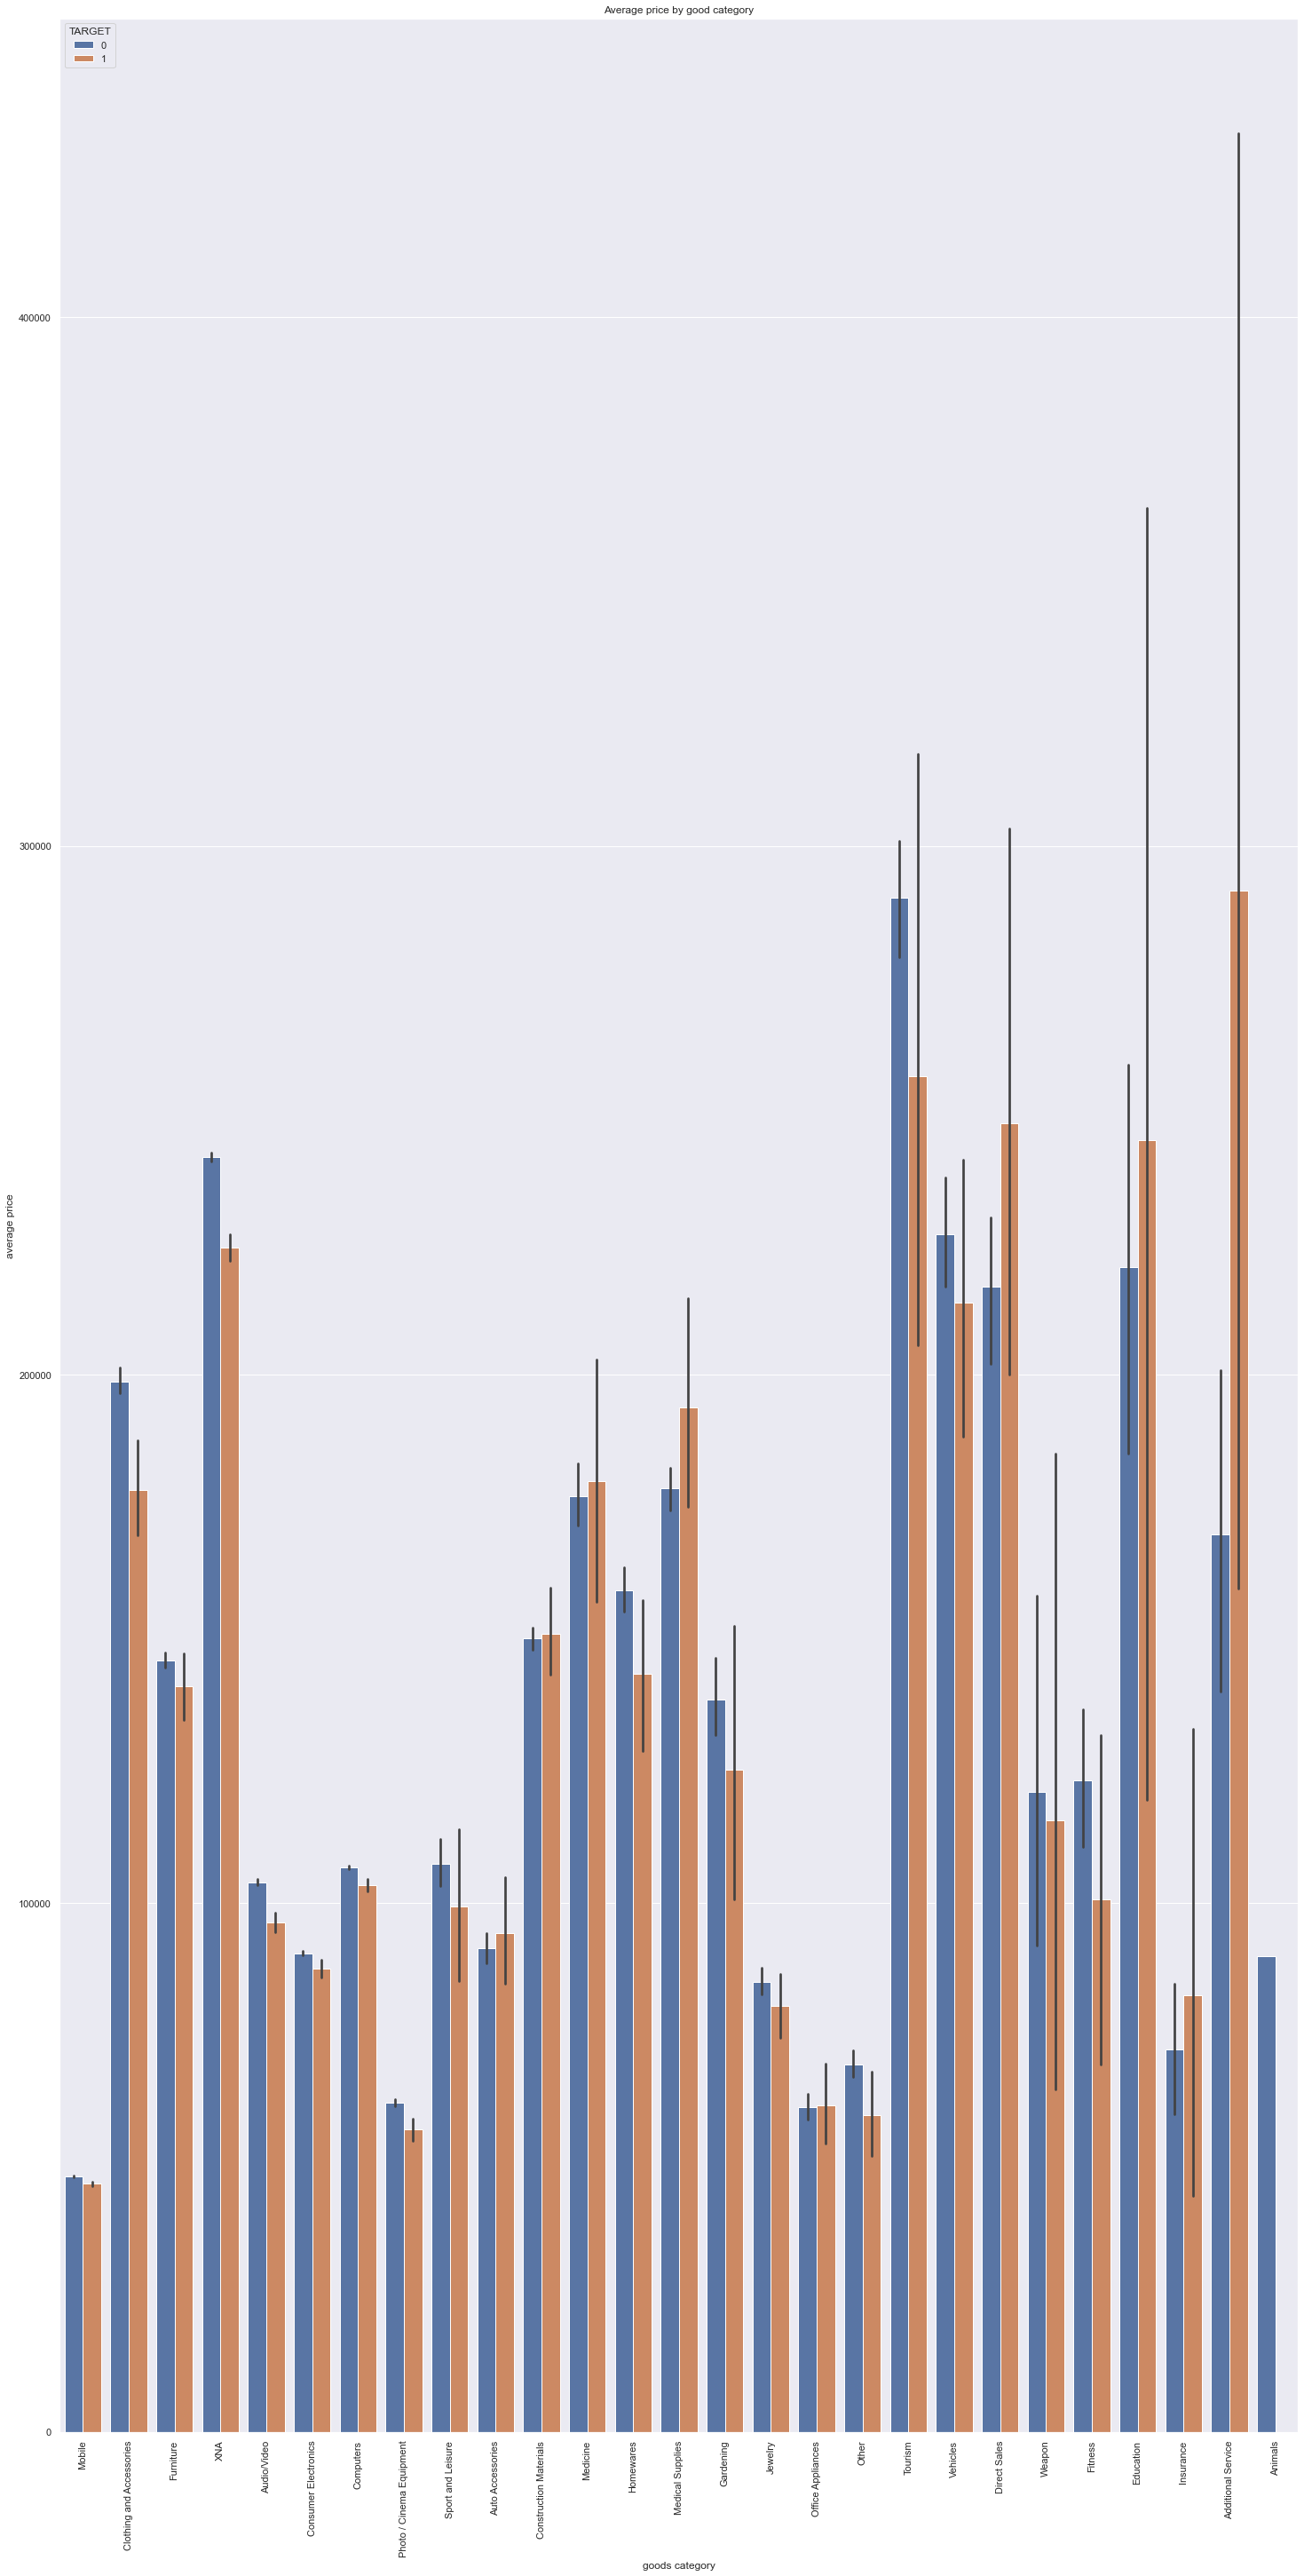

In [303]:
sns.barplot(data= previous_application_application,x='NAME_GOODS_CATEGORY',y = 'AMT_APPLICATION',hue='TARGET', estimator= np.mean)
plt.xticks(rotation = 90)
plt.xlabel('goods category')
plt.ylabel('average price')
plt.title('Average price by good category')
plt.show()

NAME_CASH_LOAN_PURPOSE

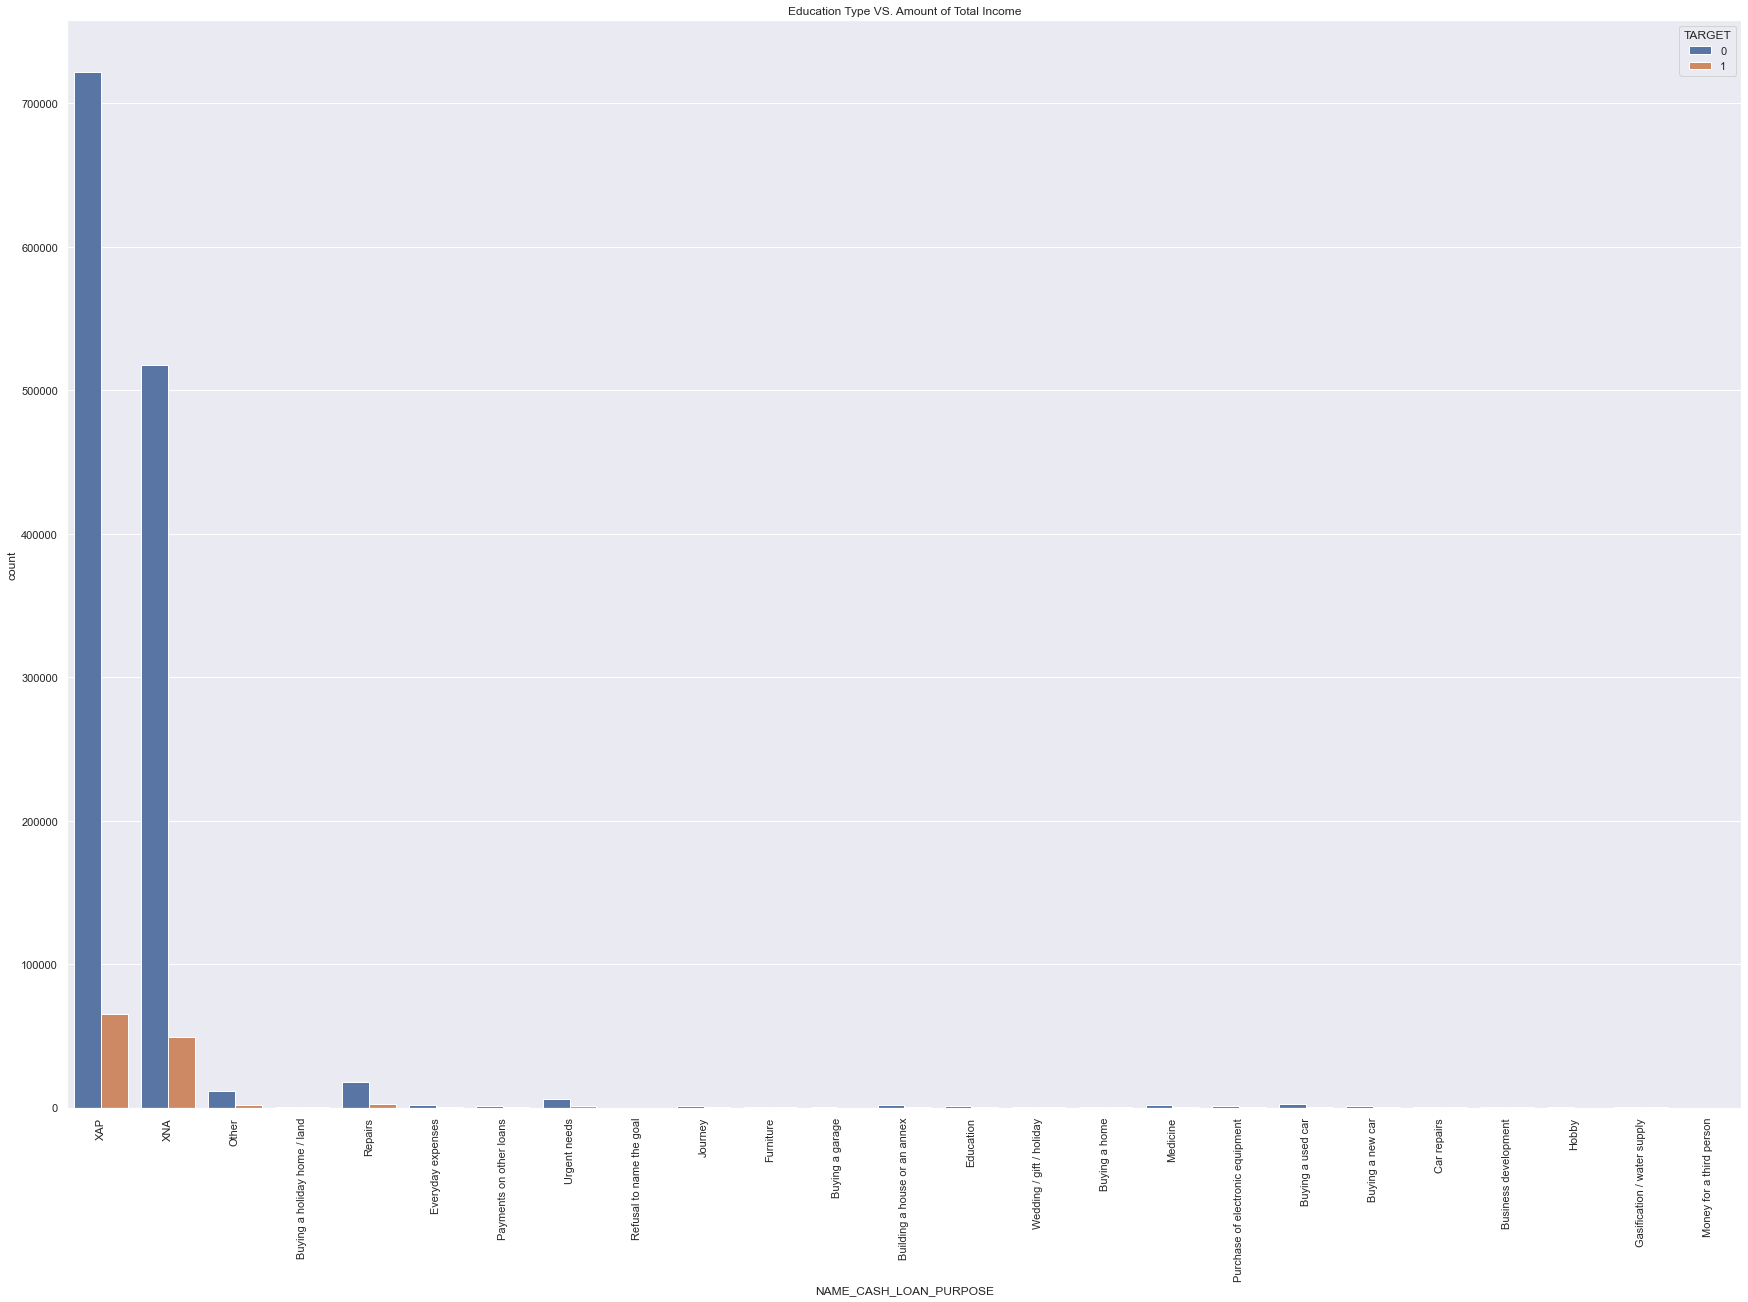

In [306]:
plt.figure(figsize=(30,20))
sns.countplot(data=previous_application_application,x='NAME_CASH_LOAN_PURPOSE'
            ,hue='TARGET')
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

## Missing Values Imputations for Main table

In [ ]:
import missingno as mn

In [ ]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [ ]:
missing_value_cnt_train = missing_data(train_data)

In [ ]:
missing_value_cnt_test = missing_data(test_data)

In [ ]:
missing_value_cnt_test

In [ ]:
total_missing_cnt = missing_value_cnt_test.merge(missing_value_cnt_train,how='inner',left_index= True, 
                             right_index=True, suffixes=['_test','_train'])

In [ ]:
col_over50_missing = total_missing_cnt[(total_missing_cnt['Percent_test']>50) &
                                       (total_missing_cnt['Percent_train']>50)]

In [ ]:
total_missing_cnt['diff'] = total_missing_cnt['Percent_test'] - total_missing_cnt['Percent_train']

In [ ]:
col_without_null = total_missing_cnt[(total_missing_cnt['Total_test'] == 0) 
                                     &(total_missing_cnt['Total_train'] == 0)].index

In [ ]:
col_with_null = total_missing_cnt.index.difference(col_without_null)

In [ ]:
col_with_null.shape

In [ ]:
col_over50_missing.index.shape

In [ ]:
col_without_null.shape

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,15), sharey=True)
ax1 = sns.barplot(y = total_missing_cnt.index, x ='Percent_test', data=total_missing_cnt,ax=ax1,
                  palette=plt.cm.magma(total_missing_cnt['Percent_test']*.01))
ax1.set_xlim(75,0)
ax1.set_xlabel('Percent of Data Missing')
ax1.set_title('Test Set Percent Missing')
ax1.set_ylabel('Independent Variables')

ax2 = sns.barplot(y = total_missing_cnt.index, x ="diff", data=total_missing_cnt,ax=ax2,
                  palette=plt.cm.magma(total_missing_cnt['diff']*.01))
ax2.set_xlabel('Difference between Test/Train Missing count')
ax2.set_title('Difference between Test/Train Missing count')
ax2.set_xlim(-15,15)
ax2.axvline(x=0, c = "r")
ax2.set_ylabel('')

ax3 = sns.barplot(y = total_missing_cnt.index, x ="Percent_train", data=total_missing_cnt,ax=ax3,
                  palette=plt.cm.magma(total_missing_cnt['Percent_train']*.01))
ax3.set_xlabel('Percent of Data Missing')
ax3.set_title('Train Set Percent Missing')
ax3.set_ylabel('')

f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
mn.matrix(test_data)
plt.show()

In [ ]:
mn.matrix(train_data)
plt.show()

In [ ]:
from sklearn.impute import SimpleImputer

### Missing Values Imputation for Train Dataset

In [ ]:
col_with_null_cat_train = train_data[col_with_null].select_dtypes(include = 'object').columns

In [ ]:
col_with_null_num_train = col_with_null.difference(col_with_null_cat_train)

In [ ]:
train_data[col_with_null_num_train].isnull().sum()

In [ ]:
missing_imputer_num = SimpleImputer(strategy= 'mean',missing_values=np.nan)
train_data[col_with_null_num_train] = missing_imputer_num.fit_transform(train_data[col_with_null_num_train])

In [ ]:
train_data[col_with_null_num_train].isnull().sum().sum()

In [ ]:
train_data[col_with_null_cat_train].isnull().sum()/train_data[col_with_null_cat_train].shape[0]

In [ ]:
missing_imputer_cat = SimpleImputer(strategy= 'most_frequent',missing_values=np.nan)
train_data[col_with_null_cat_train] = missing_imputer_cat.fit_transform(train_data[col_with_null_cat_train])

In [ ]:
train_data[col_with_null_cat_train].isnull().sum()

### Missing Values Imputation for Test Dataset


In [ ]:
col_with_null_cat_test = test_data[col_with_null].select_dtypes(include = 'object').columns

In [ ]:
col_with_null_num_test = col_with_null.difference(col_with_null_cat_test)

In [ ]:
test_data[col_with_null_num_test].isnull().sum()

In [ ]:
missing_imputer_num = SimpleImputer(strategy= 'mean',missing_values=np.nan)
test_data[col_with_null_num_test] = missing_imputer_num.fit_transform(test_data[col_with_null_num_test])

In [ ]:
missing_imputer_cat = SimpleImputer(strategy= 'most_frequent',missing_values=np.nan)
test_data[col_with_null_cat_test] = missing_imputer_cat.fit_transform(test_data[col_with_null_cat_test])

In [ ]:
test_data.isnull().sum().sum()

## Duplication Check

In [ ]:
train_duplicate = train_data.duplicated()
train_data[train_duplicate].shape[0]

# Feature Engineering

## Encoding Categorical Columns

### Label Encoding

In [ ]:
cat_col = train_data.select_dtypes(include='object').columns

In [ ]:
for i in cat_col:
    print(f'The column of {i} has unique values \n {train_data[i].unique()}\n\n')

In [ ]:
label_encode_col = ['WEEKDAY_APPR_PROCESS_START','NAME_EDUCATION_TYPE']

In [ ]:
mapping_weekday = {'MONDAY':1,'TUESDAY':2,'WEDNESDAY':3,'THURSDAY':4,'FRIDAY':5,'SATURDAY':0,'SUNDAY':6}
mapping_education = {'Lower secondary':0,'Secondary / secondary special':1,'Incomplete higher':2,'Higher education':3,'Academic degree':4}

In [ ]:
train_data['WEEKDAY_APPR_PROCESS_START_label'] = train_data['WEEKDAY_APPR_PROCESS_START'].map(mapping_weekday)
train_data['NAME_EDUCATION_TYPE_label'] = train_data['NAME_EDUCATION_TYPE'].map(mapping_education)


In [ ]:
test_data['WEEKDAY_APPR_PROCESS_START_label'] = test_data['WEEKDAY_APPR_PROCESS_START'].map(mapping_weekday)
test_data['NAME_EDUCATION_TYPE_label'] = test_data['NAME_EDUCATION_TYPE'].map(mapping_education)

In [ ]:
onehot_encode_ = list(cat_col.difference(label_encode_col))
onehot_encode_

### One-hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

In [ ]:
for col in onehot_encode_:
    subcategory = pd.DataFrame(train_data[col])
    encoded = ohe.fit_transform(subcategory)
    dense_array = encoded.toarray()
    # Put into a dataframe to get column names
    encoded_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
    train_data = pd.concat((train_data,encoded_df),axis='columns')

In [ ]:
for col in onehot_encode_:
    subcategory = pd.DataFrame(test_data[col])
    encoded = ohe.fit_transform(subcategory)
    dense_array = encoded.toarray()
    # Put into a dataframe to get column names
    encoded_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
    test_data = pd.concat((test_data,encoded_df),axis='columns')

In [ ]:
clean_train_df = train_data.drop(columns =cat_col)

clean_test_df = test_data.drop(columns = cat_col)



In [ ]:
clean_test_df.shape == clean_train_df.shape

In [ ]:
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

In [ ]:
Diff(clean_test_df,clean_train_df)

In [ ]:
clean_test_df.shape[0]

In [ ]:
d = {('Maternity leave',):[0]*(clean_test_df.shape[0]),('Unknown',):[0]*clean_test_df.shape[0]}
df = pd.DataFrame(data=d)
clean_test_df = pd.concat((clean_test_df,df),axis='columns')


In [ ]:
Diff(clean_test_df,clean_train_df)

# Modeling

## Feature Selection

### Remove Multicolinearity

In [ ]:
# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
corr_matrix = clean_train_df.corr().abs()
corr_matrix.head()

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix)
plt.title('Correlation Heatmap among variables')
plt.show()

In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

In [ ]:
clean_train_df = clean_train_df.drop(columns = to_drop,axis='columns')
clean_test_df = clean_test_df.drop(columns = to_drop,axis='columns')

print('Training shape: ', clean_train_df.shape)
print('Testing shape: ', clean_test_df.shape)

## Base Model

In [ ]:
## Scaling
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train = clean_train_df.drop('TARGET',axis='columns')
y_train = clean_train_df['TARGET']
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled =  min_max_scaler.fit_transform(clean_test_df)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
logreg = LogisticRegression(solver = 'liblinear')
params = {'C':[0.01,0.1,1,10,100]}
grid_search = GridSearchCV(estimator=logreg,param_grid=params,n_jobs=-1,cv=10)
grid_search.fit(X_train_scaled,y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
logreg = LogisticRegression(C=0.1,solver= 'liblinear')
logreg.fit(X_train_scaled,y_train)
prediction = logreg.predict(X_test_scaled)

## Ensemble Model

In [ ]:
prediction.shape

In [ ]:
submit = pd.read_csv('/Users/yuegao/ML_Projects/capstone/workplace/sample_submission.csv')
submit.head()

In [ ]:
submit['TARGET'] = prediction
submit.head()

In [ ]:
submit.to_csv('log_reg_baseline.csv', index = False)

In [63]:
col_with_null_cat_test = test_data[col_with_null].select_dtypes(include = 'object').columns

In [64]:
col_with_null_num_test = col_with_null.difference(col_with_null_cat_test)

In [65]:
test_data[col_with_null_num_test].isnull().sum()

AMT_ANNUITY                        24
AMT_GOODS_PRICE                     0
AMT_REQ_CREDIT_BUREAU_DAY        6049
AMT_REQ_CREDIT_BUREAU_HOUR       6049
AMT_REQ_CREDIT_BUREAU_MON        6049
                                ...  
YEARS_BEGINEXPLUATATION_MEDI    22856
YEARS_BEGINEXPLUATATION_MODE    22856
YEARS_BUILD_AVG                 31818
YEARS_BUILD_MEDI                31818
YEARS_BUILD_MODE                31818
Length: 61, dtype: int64

In [66]:
missing_imputer_num = SimpleImputer(strategy= 'mean',missing_values=np.nan)
test_data[col_with_null_num_test] = missing_imputer_num.fit_transform(test_data[col_with_null_num_test])

In [67]:
missing_imputer_cat = SimpleImputer(strategy= 'most_frequent',missing_values=np.nan)
test_data[col_with_null_cat_test] = missing_imputer_cat.fit_transform(test_data[col_with_null_cat_test])

In [68]:
test_data.isnull().sum().sum()

0

## Duplication Check

In [69]:
train_duplicate = train_data.duplicated()
train_data[train_duplicate].shape[0]

0

# Feature Engineering

## Encoding Categorical Columns

### Label Encoding

In [70]:
cat_col = train_data.select_dtypes(include='object').columns

In [71]:
for i in cat_col:
    print(f'The column of {i} has unique values \n {train_data[i].unique()}\n\n')

The column of NAME_CONTRACT_TYPE has unique values 
 ['Cash loans' 'Revolving loans']


The column of CODE_GENDER has unique values 
 ['M' 'F' 'XNA']


The column of FLAG_OWN_CAR has unique values 
 ['N' 'Y']


The column of FLAG_OWN_REALTY has unique values 
 ['Y' 'N']


The column of NAME_TYPE_SUITE has unique values 
 ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' 'Other_B'
 'Group of people']


The column of NAME_INCOME_TYPE has unique values 
 ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']


The column of NAME_EDUCATION_TYPE has unique values 
 ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


The column of NAME_FAMILY_STATUS has unique values 
 ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']


The column of NAME_HOUSING_TYPE has unique values 
 ['House / apartment' 'Rented apartment' 'With parent

In [72]:
label_encode_col = ['WEEKDAY_APPR_PROCESS_START','NAME_EDUCATION_TYPE']

In [73]:
mapping_weekday = {'MONDAY':1,'TUESDAY':2,'WEDNESDAY':3,'THURSDAY':4,'FRIDAY':5,'SATURDAY':0,'SUNDAY':6}
mapping_education = {'Lower secondary':0,'Secondary / secondary special':1,'Incomplete higher':2,'Higher education':3,'Academic degree':4}

In [74]:
train_data['WEEKDAY_APPR_PROCESS_START_label'] = train_data['WEEKDAY_APPR_PROCESS_START'].map(mapping_weekday)
train_data['NAME_EDUCATION_TYPE_label'] = train_data['NAME_EDUCATION_TYPE'].map(mapping_education)


In [75]:
test_data['WEEKDAY_APPR_PROCESS_START_label'] = test_data['WEEKDAY_APPR_PROCESS_START'].map(mapping_weekday)
test_data['NAME_EDUCATION_TYPE_label'] = test_data['NAME_EDUCATION_TYPE'].map(mapping_education)

In [76]:
onehot_encode_ = list(cat_col.difference(label_encode_col))
onehot_encode_

['CODE_GENDER',
 'EMERGENCYSTATE_MODE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'NAME_CONTRACT_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'NAME_INCOME_TYPE',
 'NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'WALLSMATERIAL_MODE']

### One-hot Encoding

In [77]:
from sklearn.preprocessing import OneHotEncoder
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

In [78]:
for col in onehot_encode_:
    subcategory = pd.DataFrame(train_data[col])
    encoded = ohe.fit_transform(subcategory)
    dense_array = encoded.toarray()
    # Put into a dataframe to get column names
    encoded_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
    train_data = pd.concat((train_data,encoded_df),axis='columns')

In [79]:
for col in onehot_encode_:
    subcategory = pd.DataFrame(test_data[col])
    encoded = ohe.fit_transform(subcategory)
    dense_array = encoded.toarray()
    # Put into a dataframe to get column names
    encoded_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
    test_data = pd.concat((test_data,encoded_df),axis='columns')

In [80]:
clean_train_df = train_data.drop(columns =cat_col)

clean_test_df = test_data.drop(columns = cat_col)



In [81]:
clean_test_df.shape == clean_train_df.shape

False

In [82]:
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

In [83]:
Diff(clean_test_df,clean_train_df)

['TARGET', ('Maternity leave',), ('Unknown',)]

In [84]:
clean_test_df.shape[0]

48744

In [85]:
d = {('Maternity leave',):[0]*(clean_test_df.shape[0]),('Unknown',):[0]*clean_test_df.shape[0]}
df = pd.DataFrame(data=d)
clean_test_df = pd.concat((clean_test_df,df),axis='columns')


In [86]:
Diff(clean_test_df,clean_train_df)

['TARGET']

# Modeling

## Feature Selection

### Remove Multicolinearity

In [87]:
# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
corr_matrix = clean_train_df.corr().abs()
corr_matrix.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,"(Transport: type 4,)","(University,)","(XNA,)","(Block,)","(Mixed,)","(Monolithic,)","(Others,)","(Panel,)","(Stone, brick,)","(Wooden,)"
SK_ID_CURR,1.000000,0.002108,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,0.001500,0.001366,...,0.002658,0.000496,0.001368,0.002073,0.000976,0.000072,0.001396,0.000857,0.001281,0.000270
TARGET,0.002108,1.000000,0.019187,0.003982,0.030369,0.012817,0.039628,0.037227,0.078239,0.044932,...,0.005929,0.007672,0.045987,0.006777,0.001713,0.009384,0.000628,0.013618,0.012657,0.007946
CNT_CHILDREN,0.001129,0.019187,1.000000,0.012882,0.002145,0.021374,0.001826,0.025573,0.330938,0.239818,...,0.011959,0.000854,0.240722,0.005272,0.000709,0.001607,0.002032,0.021847,0.025088,0.011036
AMT_INCOME_TOTAL,0.001820,0.003982,0.012882,1.000000,0.156870,0.191657,0.159600,0.074796,0.027261,0.064223,...,0.012323,0.005098,0.064038,0.011696,0.006149,0.023886,0.003886,0.024403,0.016523,0.003369
AMT_CREDIT,0.000343,0.030369,0.002145,0.156870,1.000000,0.770127,0.986588,0.099738,0.055436,0.066838,...,0.012154,0.017552,0.065594,0.014314,0.007987,0.027255,0.005799,0.019298,0.009756,0.007373


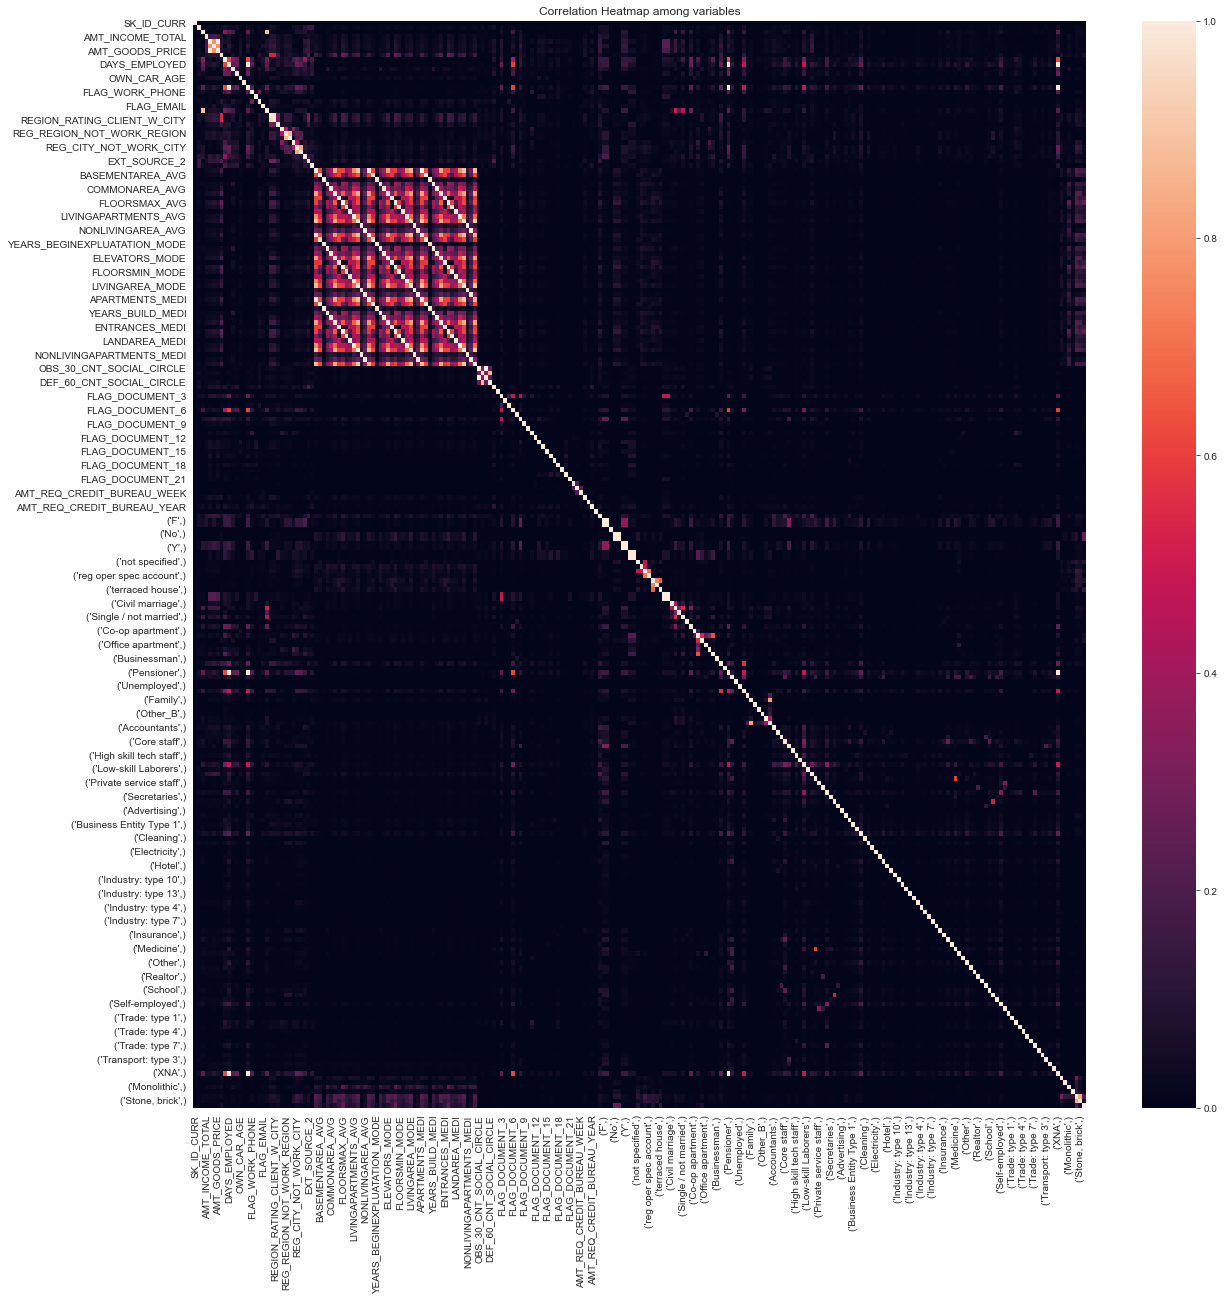

In [88]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix)
plt.title('Correlation Heatmap among variables')
plt.show()

In [89]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

/var/folders/xy/406yv2ts4sqg09841vwh_phm0000gn/T/ipykernel_58145/1832695365.py:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,"(Transport: type 4,)","(University,)","(XNA,)","(Block,)","(Mixed,)","(Monolithic,)","(Others,)","(Panel,)","(Stone, brick,)","(Wooden,)"
SK_ID_CURR,NaN,0.002108,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,0.001500,0.001366,...,0.002658,0.000496,0.001368,0.002073,0.000976,0.000072,0.001396,0.000857,0.001281,0.000270
TARGET,NaN,NaN,0.019187,0.003982,0.030369,0.012817,0.039628,0.037227,0.078239,0.044932,...,0.005929,0.007672,0.045987,0.006777,0.001713,0.009384,0.000628,0.013618,0.012657,0.007946
CNT_CHILDREN,NaN,NaN,NaN,0.012882,0.002145,0.021374,0.001826,0.025573,0.330938,0.239818,...,0.011959,0.000854,0.240722,0.005272,0.000709,0.001607,0.002032,0.021847,0.025088,0.011036
AMT_INCOME_TOTAL,NaN,NaN,NaN,NaN,0.156870,0.191657,0.159600,0.074796,0.027261,0.064223,...,0.012323,0.005098,0.064038,0.011696,0.006149,0.023886,0.003886,0.024403,0.016523,0.003369
AMT_CREDIT,NaN,NaN,NaN,NaN,NaN,0.770127,0.986588,0.099738,0.055436,0.066838,...,0.012154,0.017552,0.065594,0.014314,0.007987,0.027255,0.005799,0.019298,0.009756,0.007373


In [90]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 51 columns to remove.


In [91]:
clean_train_df = clean_train_df.drop(columns = to_drop,axis='columns')
clean_test_df = clean_test_df.drop(columns = to_drop,axis='columns')

print('Training shape: ', clean_train_df.shape)
print('Testing shape: ', clean_test_df.shape)

/Users/yuegao/opt/anaconda3/envs/capstone_proj/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Training shape:  (307511, 185)
Testing shape:  (48744, 184)


/Users/yuegao/opt/anaconda3/envs/capstone_proj/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



## Base Model

In [92]:
## Scaling
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train = clean_train_df.drop('TARGET',axis='columns')
y_train = clean_train_df['TARGET']
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled =  min_max_scaler.fit_transform(clean_test_df)

/Users/yuegao/opt/anaconda3/envs/capstone_proj/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.

/Users/yuegao/opt/anaconda3/envs/capstone_proj/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.

/Users/yuegao/opt/anaconda3/envs/capstone_proj/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.

/Users/yuegao/opt/anaconda3/envs/capstone_proj/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['s

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [94]:
logreg = LogisticRegression(solver = 'liblinear')
params = {'C':[0.01,0.1,1,10,100]}
grid_search = GridSearchCV(estimator=logreg,param_grid=params,n_jobs=-1,cv=10)
grid_search.fit(X_train_scaled,y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: name 'grid_result' is not defined

In [ ]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
logreg = LogisticRegression(C=0.1,solver= 'liblinear')
logreg.fit(X_train_scaled,y_train)
prediction = logreg.predict(X_test_scaled)

## Ensemble Model

In [ ]:
prediction.shape

In [ ]:
submit = pd.read_csv('/Users/yuegao/ML_Projects/capstone/workplace/sample_submission.csv')
submit.head()

In [ ]:
submit['TARGET'] = prediction
submit.head()

In [ ]:
submit.to_csv('log_reg_baseline.csv', index = False)

In [ ]:
col_with_null_num_test = col_with_null.difference(col_with_null_cat_test)

In [ ]:
test_data[col_with_null_num_test].isnull().sum()

In [ ]:
missing_imputer_num = SimpleImputer(strategy= 'mean',missing_values=np.nan)
test_data[col_with_null_num_test] = missing_imputer_num.fit_transform(test_data[col_with_null_num_test])

In [ ]:
missing_imputer_cat = SimpleImputer(strategy= 'most_frequent',missing_values=np.nan)
test_data[col_with_null_cat_test] = missing_imputer_cat.fit_transform(test_data[col_with_null_cat_test])

In [ ]:
test_data.isnull().sum().sum()

## Duplication Check

In [ ]:
train_duplicate = train_data.duplicated()
train_data[train_duplicate].shape[0]

# Feature Engineering

## Encoding Categorical Columns

### Label Encoding

In [ ]:
cat_col = train_data.select_dtypes(include='object').columns

In [ ]:
for i in cat_col:
    print(f'The column of {i} has unique values \n {train_data[i].unique()}\n\n')

In [ ]:
label_encode_col = ['WEEKDAY_APPR_PROCESS_START','NAME_EDUCATION_TYPE']

In [ ]:
mapping_weekday = {'MONDAY':1,'TUESDAY':2,'WEDNESDAY':3,'THURSDAY':4,'FRIDAY':5,'SATURDAY':0,'SUNDAY':6}
mapping_education = {'Lower secondary':0,'Secondary / secondary special':1,'Incomplete higher':2,'Higher education':3,'Academic degree':4}

In [ ]:
train_data['WEEKDAY_APPR_PROCESS_START_label'] = train_data['WEEKDAY_APPR_PROCESS_START'].map(mapping_weekday)
train_data['NAME_EDUCATION_TYPE_label'] = train_data['NAME_EDUCATION_TYPE'].map(mapping_education)


In [ ]:
test_data['WEEKDAY_APPR_PROCESS_START_label'] = test_data['WEEKDAY_APPR_PROCESS_START'].map(mapping_weekday)
test_data['NAME_EDUCATION_TYPE_label'] = test_data['NAME_EDUCATION_TYPE'].map(mapping_education)

In [ ]:
onehot_encode_ = list(cat_col.difference(label_encode_col))
onehot_encode_

### One-hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

In [ ]:
for col in onehot_encode_:
    subcategory = pd.DataFrame(train_data[col])
    encoded = ohe.fit_transform(subcategory)
    dense_array = encoded.toarray()
    # Put into a dataframe to get column names
    encoded_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
    train_data = pd.concat((train_data,encoded_df),axis='columns')

In [ ]:
for col in onehot_encode_:
    subcategory = pd.DataFrame(test_data[col])
    encoded = ohe.fit_transform(subcategory)
    dense_array = encoded.toarray()
    # Put into a dataframe to get column names
    encoded_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
    test_data = pd.concat((test_data,encoded_df),axis='columns')

In [ ]:
clean_train_df = train_data.drop(columns =cat_col)

clean_test_df = test_data.drop(columns = cat_col)



In [ ]:
clean_test_df.shape == clean_train_df.shape

In [ ]:
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

In [ ]:
Diff(clean_test_df,clean_train_df)

In [ ]:
clean_test_df.shape[0]

In [ ]:
d = {('Maternity leave',):[0]*(clean_test_df.shape[0]),('Unknown',):[0]*clean_test_df.shape[0]}
df = pd.DataFrame(data=d)
clean_test_df = pd.concat((clean_test_df,df),axis='columns')


In [ ]:
Diff(clean_test_df,clean_train_df)

# Modeling

## Feature Selection

### Remove Multicolinearity

In [ ]:
# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
corr_matrix = clean_train_df.corr().abs()
corr_matrix.head()

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix)
plt.title('Correlation Heatmap among variables')
plt.show()

In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

In [ ]:
clean_train_df = clean_train_df.drop(columns = to_drop,axis='columns')
clean_test_df = clean_test_df.drop(columns = to_drop,axis='columns')

print('Training shape: ', clean_train_df.shape)
print('Testing shape: ', clean_test_df.shape)

## Base Model

In [ ]:
## Scaling
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train = clean_train_df.drop('TARGET',axis='columns')
y_train = clean_train_df['TARGET']
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled =  min_max_scaler.fit_transform(clean_test_df)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
logreg = LogisticRegression(solver = 'liblinear')
params = {'C':[0.01,0.1,1,10,100]}
grid_search = GridSearchCV(estimator=logreg,param_grid=params,n_jobs=-1,cv=10)
grid_search.fit(X_train_scaled,y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
logreg = LogisticRegression(C=0.1,solver= 'liblinear')
logreg.fit(X_train_scaled,y_train)
prediction = logreg.predict(X_test_scaled)

## Ensemble Model

In [ ]:
prediction.shape

In [ ]:
submit = pd.read_csv('/Users/yuegao/ML_Projects/capstone/workplace/sample_submission.csv')
submit.head()

In [ ]:
submit['TARGET'] = prediction
submit.head()

In [ ]:
submit.to_csv('log_reg_baseline.csv', index = False)